# COVID-19 Global Forecasting

## Table Of Contents:
* [Introduction](#intro)
* [Importing libraries](#imports)
* [Covid-19 Data: First look](#data)
* [Preprocessing](#cleaning)
* [Exploratory Data Analysis](#EDA)
    * [Active Cases Distribution](#EDA4)
    * [Closed Cases Distribution](#EDA5)
    * [Moratality and Recovery Rate analysis](#EDA6)
    * [Growth Factor](#EDA7)
    * [Analysis by country](#EDA8)
        * [Top 10 countries with most *Active* and *Closed* Cases](#EDA8.1)
        * [Survival probabilty per country](#EDA8.2)
        * [Looking for similar countries](#EDA8.3)
    * [Global ConfirmedCases and Fatalities Trend](#EDA1)
    * [COVID-19 trends in China](#EDA2)
    * [Other Interesting countries to look at: Canada, USA, Italy, Spain, South Korea, Germany, Tunisia](#EDA3)
* [Machine Learning Models](#ML)
    * [Linear Regression](#LR)
    * [Polynomial Regression](#PR)
    * [Support Vector Machine Regressor](#svm)
    * [Predictions](#predictions1)
* [Time Series Models](#TS)
    * [ARIMA](#arima)
    * [SARIMA](#sarima)
    * [Predictions](#predictions2)
* [Models' Summary](#summary)
* [Conclusions](#conclusions)

# Introduction <a class="anchor" id="intro"></a>

#### Corona Virus
* Coronaviruses are zoonotic viruses (means transmitted between animals and people).
* Symptoms include from fever, cough, respiratory symptoms, and breathing difficulties.
* In severe cases, it can cause pneumonia, severe acute respiratory syndrome (SARS), kidney failure and even death.
* Coronaviruses are also asymptomatic, means a person can be a carrier for the infection but experiences no symptoms

#### COVID-19 (Corona Virus Disease 2019)
* Caused by a SARS-COV-2 corona virus.
* First identified in Wuhan, Hubei, China. Earliest reported symptoms reported in November 2019.
* First cases were linked to contact with the Huanan Seafood Wholesale Market, which sold live animals.
* On 30 January the WHO declared the outbreak to be a Public Health Emergency of International Concern

# Importing libraries <a class="anchor" id="imports"></a>

In [297]:
# Data Manipulation and Processing
import pandas as pd
# Linear algebra and calculus tools
import numpy as np
from scipy import integrate, optimize
# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
%matplotlib inline
# Machine Learning Models
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
# ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# Preprocessing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.preprocessing import LabelBinarizer,LabelEncoder,StandardScaler,MinMaxScaler
import random
import warnings
from datetime import timedelta
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

# Useful Functions

In [144]:
def first_case_by_country(df,country):
    """
    This function takes the train dataframe and the country as inputs and
    returns the date of the first reported case.
    """
    df = get_country_data(train_data,country)[0]
    df.columns = df.columns.get_level_values(0)
    for i in df["ConfirmedCases"].values:
        if i != 0.0:
            index = list(df["ConfirmedCases"]).index(i)
            first_case_date = df["ConfirmedCases"].index[index]
            break
    return first_case_date

In [145]:
def get_population(df,country):
    """
    This function returns the population of the input country 
    """
    pop = float(df[df.Country == country+" "].Population)
    return pop

In [146]:
def get_country_data(df,country):
    """
    This function takes as input the train data frame and the country and
    returns the total of confirmed cases and fatalities per country.
    """
    confirmed = df[df['Country_Region']== country].groupby(['Date']).agg({'ConfirmedCases':['sum']})
    fatalities = df[df['Country_Region']== country].groupby(['Date']).agg({'Fatalities':['sum']})
    return confirmed,fatalities

In [147]:
def get_df_country_cases(df, country) :
    df_grouped_country = df[df['Country/Region'] == country].reset_index()
    df_grouped_country_date = df_grouped_country.groupby('Date')['Date', 'Confirmed', 'Deaths'].sum().reset_index()
    return df_grouped_country_date

In [148]:
def get_country_data_2(country):
    df_grouped = get_df_country_cases(covid_data_complete, country)
    df_cases_by_day = df_grouped[df_grouped.Confirmed > 0]
    df_cases_by_day = df_cases_by_day.reset_index(drop=True)
    df_cases_by_day['day'] = df_cases_by_day.Date.apply(lambda x: (x - df_cases_by_day.Date.min()).days)
    reordered_columns = ['Date', 'day', 'Confirmed', 'Deaths']
    df_cases_by_day = df_cases_by_day[reordered_columns]
    return df_cases_by_day

In [149]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=9,
                     header_color='#0504aa', row_colors=['#f1f1f2', 'w'], edge_color='black',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    This function converts dataframes to png
    """
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


# Covid-19 Data: First look <a class="anchor" id="data"></a>

#### "Train.csv" Dataset

In [150]:
train_data = pd.read_csv("train.csv", parse_dates=['Date']) # 15 Mai 2020

In [151]:
display(train_data.info(),
        "Head",train_data.head(),
        "Shape", train_data.shape,
       "Missing Values", train_data.isnull().sum(),
       "Descriptive Statistics", train_data.describe(),
        )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              35995 non-null  int64         
 1   Province_State  15295 non-null  object        
 2   Country_Region  35995 non-null  object        
 3   Date            35995 non-null  datetime64[ns]
 4   ConfirmedCases  35995 non-null  float64       
 5   Fatalities      35995 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.6+ MB


None

'Head'

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0,0
1,2,NaN,Afghanistan,2020-01-23,0,0
2,3,NaN,Afghanistan,2020-01-24,0,0
3,4,NaN,Afghanistan,2020-01-25,0,0
4,5,NaN,Afghanistan,2020-01-26,0,0


'Shape'

(35995, 6)

'Missing Values'

Id                    0
Province_State    20700
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

'Descriptive Statistics'

,Id,ConfirmedCases,Fatalities
count,35995,35995,35995
mean,17998,3684,244
std,10391,18987,1833
min,1,0,0
25%,9000,0,0
50%,17998,19,0
75%,26996,543,7
max,35995,345813,33998


#### "Test.csv" Dataset

In [152]:
test_data = pd.read_csv("test.csv", parse_dates=['Date']) # 15 Mai 2020

In [153]:
display(test_data.info(),
        "Head",test_data.head(),
        "Shape", test_data.shape,
       "Missing Values", test_data.isnull().sum()
        )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13459 entries, 0 to 13458
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ForecastId      13459 non-null  int64         
 1   Province_State  5719 non-null   object        
 2   Country_Region  13459 non-null  object        
 3   Date            13459 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 420.7+ KB


None

'Head'

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


'Shape'

(13459, 4)

'Missing Values'

ForecastId           0
Province_State    7740
Country_Region       0
Date                 0
dtype: int64

#### "Covid-19-data.csv" dataset

In [154]:
covid19_data = pd.read_csv("covid_19_data.csv") # 17 Mai 2020

In [155]:
display(covid19_data.info(),
        "Head",covid19_data.head(),
        "Shape", covid19_data.shape,
       "Missing Values", covid19_data.isnull().sum(),
       "Descriptive Statistics", covid19_data.describe(),
        )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25582 entries, 0 to 25581
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              25582 non-null  int64  
 1   ObservationDate  25582 non-null  object 
 2   Province/State   12294 non-null  object 
 3   Country/Region   25582 non-null  object 
 4   Last Update      25582 non-null  object 
 5   Confirmed        25582 non-null  float64
 6   Deaths           25582 non-null  float64
 7   Recovered        25582 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.6+ MB


None

'Head'

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1,0,0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14,0,0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6,0,0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1,0,0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0,0,0


'Shape'

(25582, 8)

'Missing Values'

SNo                    0
ObservationDate        0
Province/State     13288
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

'Descriptive Statistics'

,SNo,Confirmed,Deaths,Recovered
count,25582,25582,25582,25582
mean,12792,5379,352,1610
std,7385,22647,2158,10356
min,1,0,0,0
25%,6396,16,0,0
50%,12792,178,2,6
75%,19187,1265,23,164
max,25582,348232,34466,268376


# Preprocessing  <a class="anchor" id="cleaning"></a>

In [156]:
# Grouping Data by Country
covid_by_country= covid19_data[covid19_data["ObservationDate"]==covid19_data["ObservationDate"]
                               .max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',
                                                                       "Recovered":'sum',
                                                                       "Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)

In [157]:
display(covid_by_country.info(),
        "Shape", covid_by_country.shape,
        "Head",covid_by_country.head(),
        "Desciptive Statistics",covid_by_country.describe(), 
        "Missing values",covid_by_country.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, US to Lesotho
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  190 non-null    float64
 1   Recovered  190 non-null    float64
 2   Deaths     190 non-null    float64
dtypes: float64(3)
memory usage: 5.9+ KB


None

'Shape'

(190, 3)

'Head'

,Confirmed,Recovered,Deaths
Country/Region,,,
US,1467820,268376,88754
Russia,272043,63166,2537
UK,241461,1058,34546
Brazil,233511,89672,15662
Spain,230698,146446,27563


'Desciptive Statistics'

,Confirmed,Recovered,Deaths
count,190,190,190
mean,24390,8912,1641
std,114673,29750,7872
min,1,0,0
25%,235,59,4
50%,1191,536,26
75%,8400,3474,224
max,1467820,268376,88754


'Missing values'

Confirmed    0
Recovered    0
Deaths       0
dtype: int64

In [158]:
# Treating missing data (concating Province/State with Country/Region)
covid19_data["Province/State"] = covid19_data["Province/State"].fillna('')
covid19_data['Country/Region'] = covid19_data['Country/Region'] + ' ' + covid19_data['Province/State']
covid19_data.rename(columns = {"Country/Region" : "Country_State"}, inplace = True)
del covid19_data["Province/State"]

In [159]:
#Dropping column SNo
covid19_data.drop(["SNo"],1,inplace=True)

In [160]:
#Converting "Observation Date" into Datetime format
covid19_data["ObservationDate"]=pd.to_datetime(covid19_data["ObservationDate"])

In [161]:
#Grouping different types of cases as per the date
covid_by_date=covid19_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
covid_by_date["Days Since"]=covid_by_date.index-covid_by_date.index.min()

In [162]:
# Determine the intervall between each date and the date of the first case
covid_by_date["Days Since"]=covid_by_date.index-covid_by_date.index[0]
# extract the number of days from the dtate of the first case
covid_by_date["Days Since"]=covid_by_date["Days Since"].dt.days 

In [163]:
display(covid_by_date.info(),
        "Shape", covid_by_date.shape,
        "Head",covid_by_date.head(),
        "Desciptive Statistics",covid_by_date.describe(), 
        "Missing values",covid_by_date.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116 entries, 2020-01-22 to 2020-05-16
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Confirmed   116 non-null    float64
 1   Recovered   116 non-null    float64
 2   Deaths      116 non-null    float64
 3   Days Since  116 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 4.5 KB


None

'Shape'

(116, 4)

'Head'

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-22,555,28,17,0
2020-01-23,653,30,18,1
2020-01-24,941,36,26,2
2020-01-25,1438,39,42,3
2020-01-26,2118,52,56,4


'Desciptive Statistics'

,Confirmed,Recovered,Deaths,Days Since
count,116,116,116,116
mean,1186217,355090,77728,58
std,1459102,479663,102472,34
min,555,28,17,0
25%,76060,17663,2216,29
50%,257440,86182,10583,58
75%,2259583,574337,155244,86
max,4634068,1693197,311781,115


'Missing values'

Confirmed     0
Recovered     0
Deaths        0
Days Since    0
dtype: int64

# Exploratory Data Analysis <a class="anchor" id="EDA"></a>

## Active Cases Distribution <a class="anchor" id="EDA4"></a>

*__Active Cases__ = Number of Confirmed Cases - Number of Recovered Cases - Number of Death Cases*

Increase in number of Active Cases is probably an indication of Recovered case or Death case number is dropping in comparison to number of Confirmed Cases drastically. Will look for the conclusive evidence for the same in the notebook ahead.

Text(0.5, 1.0, 'Distribution of Active Cases')

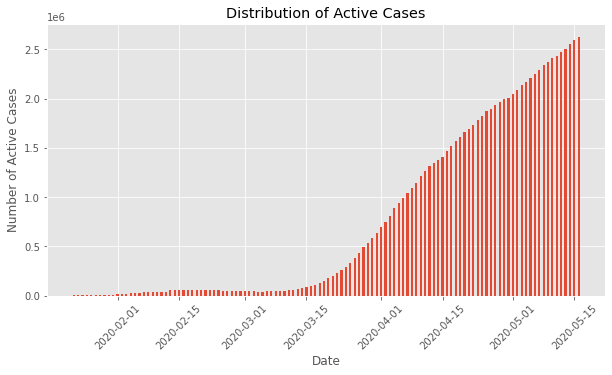

In [164]:
plt.figure(figsize=(10,5))
active_cases = covid_by_date["Confirmed"]-covid_by_date["Recovered"]-covid_by_date["Deaths"]
plt.bar(covid_by_date.index,active_cases, width=0.5)
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Number of Active Cases")
plt.title("Distribution of Active Cases")

## Closed Cases Distribution <a class="anchor" id="EDA5"></a>

*__Closed Cases__ = Number of Recovered Cases + Number of Death Cases*

Increase in number of Closed classes imply either more patients are getting recovered from the disease or more pepole are dying because of COVID-19

Text(0.5, 1.0, 'Distribution of Closed Cases')

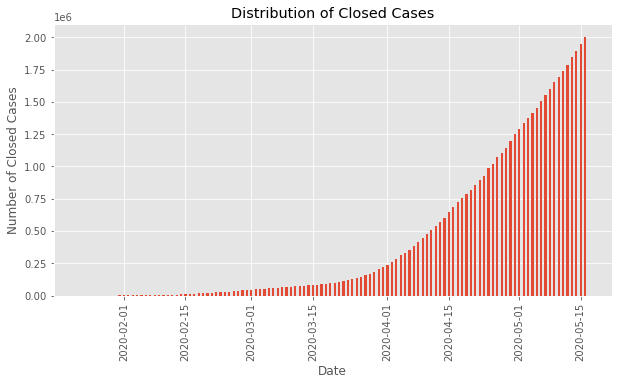

In [165]:
plt.figure(figsize=(10,5))
closed_cases = covid_by_date["Recovered"]+covid_by_date["Deaths"]
plt.bar(covid_by_date.index,closed_cases, width=0.5)
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Number of Closed Cases")
plt.title("Distribution of Closed Cases")

## Moratality and Recovery Rate analysis <a class="anchor" id="EDA6"></a>

* *__Mortality rate__ = (Number of Death Cases / Number of Confirmed Cases) x 100*
* *__Recovery Rate__= (Number of Recoverd Cases / Number of Confirmed Cases) x 100*

In [166]:
#Calculating the Mortality Rate and Recovery Rate
covid_by_date["Mortality Rate"]=(covid_by_date["Deaths"]/covid_by_date["Confirmed"])*100
covid_by_date["Recovery Rate"]=(covid_by_date["Recovered"]/covid_by_date["Confirmed"])*100
covid_by_date["Active Cases"]=covid_by_date["Confirmed"]-covid_by_date["Recovered"]-covid_by_date["Deaths"]
covid_by_date["Closed Cases"]=covid_by_date["Recovered"]+covid_by_date["Deaths"]

print("Average Mortality Rate",covid_by_date["Mortality Rate"].mean())
print("Median Mortality Rate",covid_by_date["Mortality Rate"].median())
print("Average Recovery Rate",covid_by_date["Recovery Rate"].mean())
print("Median Recovery Rate",covid_by_date["Recovery Rate"].median())

Average Mortality Rate 4.550157744868421
Median Mortality Rate 4.1083952234543
Average Recovery Rate 26.500397860180843
Median Recovery Rate 26.050190415144954


Text(0.5, 0, 'Time')

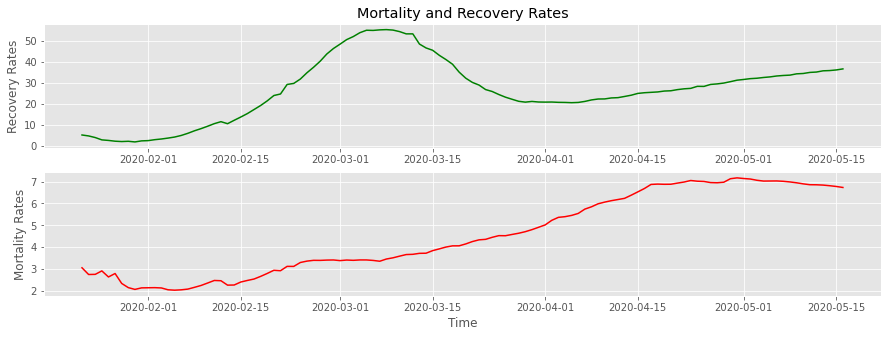

In [167]:
#Plotting Mortality and Recovery Rate 
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15,5))
ax1.plot(covid_by_date.index, (covid_by_date["Recovered"]/covid_by_date["Confirmed"])*100, color="green")
ax1.set_ylabel("Recovery Rates")
ax1.set_title("Mortality and Recovery Rates")
ax2.plot(covid_by_date.index, (covid_by_date["Deaths"]/covid_by_date["Confirmed"])*100, color="red")
ax2.set_ylabel("Mortality Rates")
ax2.set_xlabel("Time")

* __Observations__:
    * Mortality rate is showing a significant dip since past few days, which is a positive sign.
    * Recovery Rate has started to pick up again which is a good sign, another supportive reason to why number of Closed Cases are increasing

## Growth Factor <a class="anchor" id="EDA7"></a>

Growth factor is the factor by which a quantity multiplies itself over time. The formula used is:

*__Every day's new (Confirmed,Recovered,Deaths) / new (Confirmed,Recovered,Deaths) on the previous day.__*

* A growth factor __above 1 indicates an increase correspoding cases__.

* A growth factor __above 1 but trending downward__ is a positive sign, whereas a __growth factor constantly above 1 is the sign of exponential growth__.

* A growth factor __constant at 1 indicates there is no change in any kind of cases__.

Text(0.5, 1.0, 'Growth Factor for diffrent types of cases')

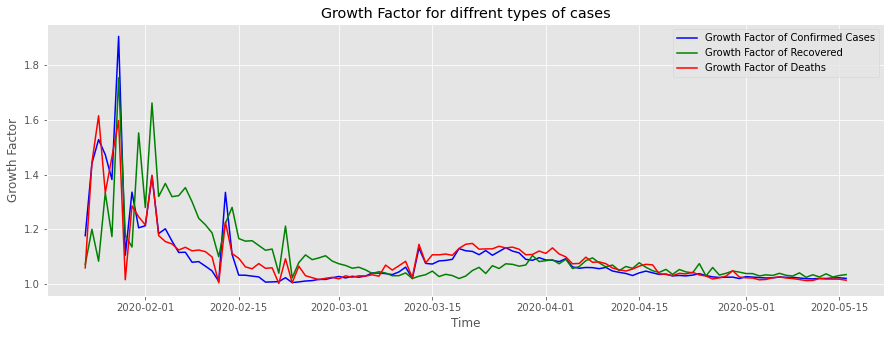

In [168]:
plt.figure(figsize=(15,5))
plt.plot(covid_by_date.index, (covid_by_date["Confirmed"]/covid_by_date["Confirmed"].shift()),color="blue")
plt.plot(covid_by_date.index, (covid_by_date["Recovered"]/covid_by_date["Recovered"].shift()), color="green")
plt.plot(covid_by_date.index, (covid_by_date["Deaths"]/covid_by_date["Deaths"].shift()), color="red")
plt.legend(["Growth Factor of Confirmed Cases","Growth Factor of Recovered","Growth Factor of Deaths"])
plt.ylabel("Growth Factor")
plt.xlabel("Time")
plt.title("Growth Factor for diffrent types of cases")

* __Obeservations__:
    * The growth factor of al type of cases is constantly above 1 which indicates an exponential growth.
    * The growth factor seems to be decreasing towards 1 with time  which is a good sign.

##  Analysis by country <a class="anchor" id="EDA8"></a>

## Top 10 countries with most *Active* and *Closed* Cases <a class="anchor" id="EDA8.1"></a>

Text(0.5, 1.0, 'Top 10 Countries with Most Number of Closed Cases')

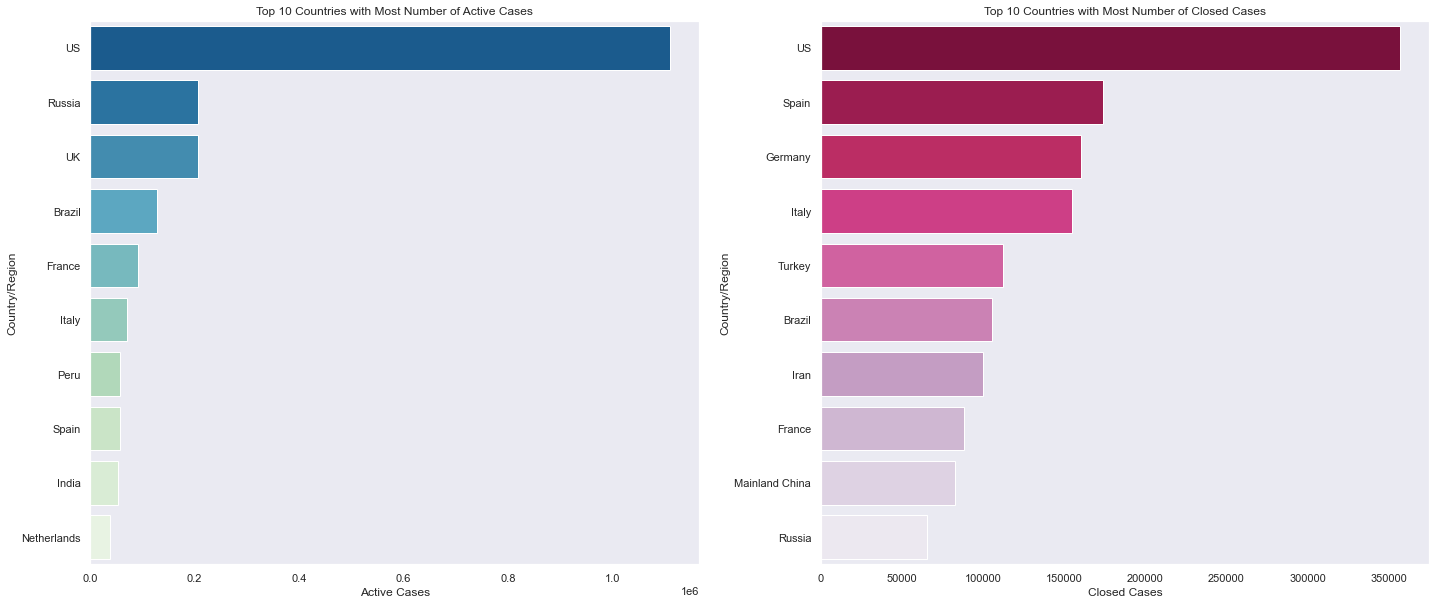

In [258]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,10))
covid_by_country["Active Cases"]=(covid_by_country["Confirmed"]-covid_by_country["Recovered"]-covid_by_country["Deaths"])
covid_by_country["Closed Cases"]=(covid_by_country["Recovered"]+covid_by_country["Deaths"])
top_10_active=covid_by_country.sort_values(["Active Cases"],ascending=False).head(10)
top_10_closed=covid_by_country.sort_values(["Closed Cases"],ascending=False).head(10)
sns.barplot(x=top_10_active["Active Cases"],y=top_10_active.index,ax=ax1,palette="GnBu_r")
sns.barplot(x=top_10_closed["Closed Cases"],y=top_10_closed.index,ax=ax2,palette="PuRd_r")
ax1.set_title("Top 10 Countries with Most Number of Active Cases")
ax2.set_title("Top 10 Countries with Most Number of Closed Cases")

## Survival probabilty per country <a class="anchor" id="EDA8.2"></a>

\begin{equation}
Survival \: probability = 1 - \frac{Deaths}{Confirmed Cases}
\end{equation}

In [263]:
covid_by_country["Survival Probability"]=(1-(covid_by_country["Deaths"]/covid_by_country["Confirmed"]))*100

In [264]:
print('Mean Survival Probability across all countries',covid_by_country["Survival Probability"].mean())
print('Median Survival Probability across all countries',covid_by_country["Survival Probability"].median())
print('Mean Death Probability across all countries',100-covid_by_country["Survival Probability"].mean())
print('Median Death Probability across all countries',100-covid_by_country["Survival Probability"].median())

Mean Survival Probability across all countries 96.07725637404114
Median Survival Probability across all countries 97.15244789880587
Mean Death Probability across all countries 3.9227436259588586
Median Death Probability across all countries 2.8475521011941254


## Looking for similar countries <a class="anchor" id="EDA8.3"></a>

To visulize the similarities between countries we will try clustering them with K-means algorithm

In [279]:
# Scaling Data
std=StandardScaler()
X=covid_by_country[["Confirmed","Deaths","Recovered"]]
X=std.fit_transform(X)

Text(0.5, 1.0, 'Silhouette Score Method')

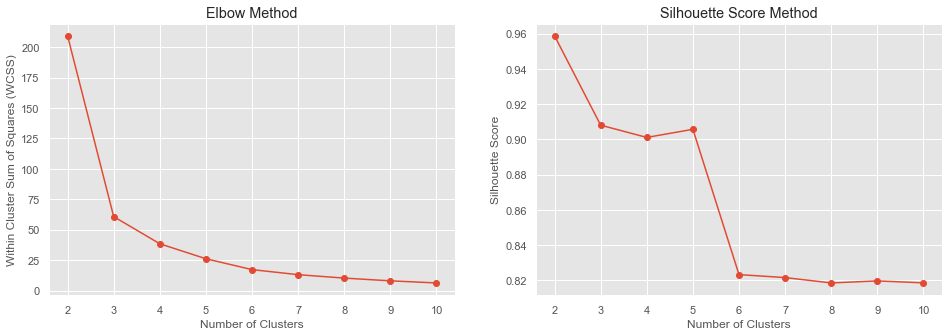

In [286]:
# Choosing the right k with the elbow and the silhouette methods
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)
    
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x=np.arange(2,11)
ax1.plot(x,wcss,marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")
x=np.arange(2,11)
ax2.plot(x,sil,marker='o')
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")

We will consider __k=5__

In [287]:
clf_final=KMeans(n_clusters=5,init='k-means++',random_state=42)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [288]:
covid_by_country["Clusters"]=clf_final.predict(X)

In [305]:
# Visulizing the clusters
cluster_summary=pd.concat([covid_by_country[covid_by_country["Clusters"]==1],
                           covid_by_country[covid_by_country["Clusters"]==2],
                           covid_by_country[covid_by_country["Clusters"]==3],
                           covid_by_country[covid_by_country["Clusters"]==4],
                           covid_by_country[covid_by_country["Clusters"]==0].head(20)])
cluster_summary.style.background_gradient(cmap='ocean_r')

,Confirmed,Recovered,Deaths,Active Cases,Closed Cases,Survival Probability,Clusters
Country/Region,,,,,,,
US,1467820.000000,268376.000000,88754.000000,1110690.000000,357130.000000,93.953346,1
Spain,230698.000000,146446.000000,27563.000000,56689.000000,174009.000000,88.052345,2
Italy,224760.000000,122810.000000,31763.000000,70187.000000,154573.000000,85.868037,2
Russia,272043.000000,63166.000000,2537.000000,206340.000000,65703.000000,99.067427,3
Brazil,233511.000000,89672.000000,15662.000000,128177.000000,105334.000000,93.292821,3
Germany,175752.000000,152600.000000,7938.000000,15214.000000,160538.000000,95.483408,3
Turkey,148067.000000,108137.000000,4096.000000,35834.000000,112233.000000,97.233685,3
Iran,118392.000000,93147.000000,6937.000000,18308.000000,100084.000000,94.140651,3
Mainland China,82947.000000,78227.000000,4634.000000,86.000000,82861.000000,94.413300,3


* __Observations__:
    * __Cluster 0__ is a set of countries which are very less affected, with comapritively low number of Confimed, Recoverd and Death Cases. e.g. India, Canada etc.

    * __Cluster 1__ is set of countries which are severly affected, with really high number of Confirmed, Recovered and Death Cases. e.g. United States is the only country which belongs to this Cluster.

    * __Cluster 3__ belongs to countries which are worst affected with high number of Confirmed Cases but having really good number of Recoverd Cases, with comparitively low Mortality Rate. e.g. Germany, Russia, Iran, Brazil etc.

    * __Cluster 2__ belongs to countries which are badly affected with high number of Confirmed Cases but having really good number of Recoverd Cases, but high Mortality Rate e.g. Italy, Spain etc.

    * __Cluster 4__ is somehow similar to Cluster 2, but high Mortality Rate compared to Cluster 2 also the number of Active Cases are high as compared to Cluster 2 e.g. United Kingdom, France etc.

## Global ConfirmedCases and Fatalities Trend <a class="anchor" id="EDA1"></a>

Text(0.5, 0, 'Date')

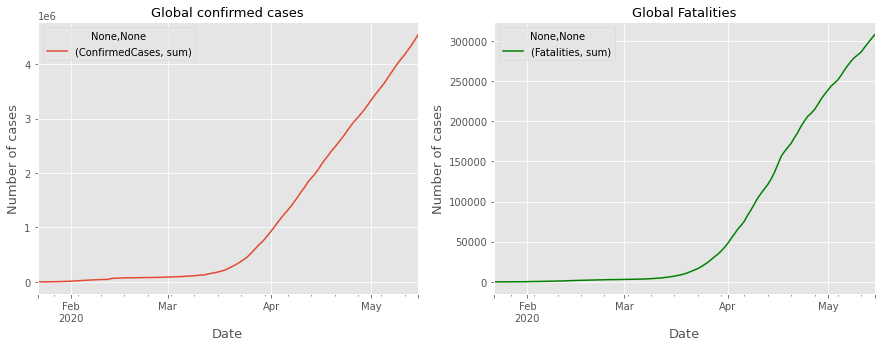

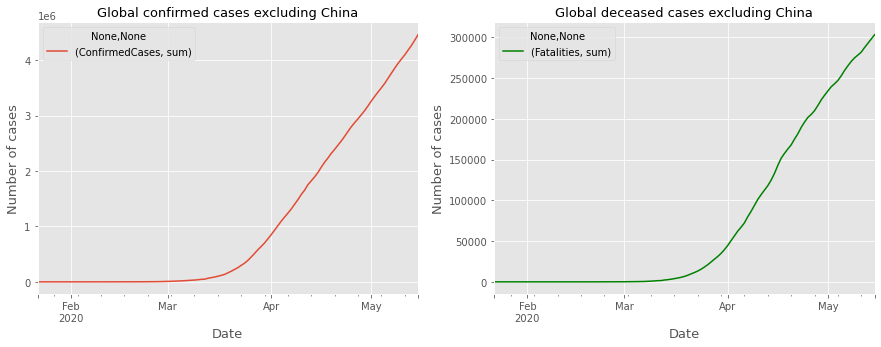

In [169]:
# Aggregate confirmed cases and fatalities across all countries
confirmed_total_date = train_data.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train_data.groupby(['Date']).agg({'Fatalities':['sum']})

# Exclude China in our training data plots
confirmed_total_date_noChina = train_data[train_data['Country_Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train_data[train_data['Country_Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})

# Plot global confirmed cases 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
confirmed_total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

# Plot global fatalities
fatalities_total_date.plot(ax=ax2, color='green')
ax2.set_title("Global Fatalities", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)
#plt.savefig("global-trends.png")
# Plot confirmed cases in china
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15,5))
confirmed_total_date_noChina.plot(ax=ax3)
ax3.set_title("Global confirmed cases excluding China", size=13)
ax3.set_ylabel("Number of cases", size=13)
ax3.set_xlabel("Date", size=13)

# Plot the fatalities in china
fatalities_total_date_noChina.plot(ax=ax4, color='green')
ax4.set_title("Global deceased cases excluding China", size=13)
ax4.set_ylabel("Number of cases", size=13)
ax4.set_xlabel("Date", size=13)
#plt.savefig("global-noChina-trends.png")

__Observations:__

* The global curve numbers are strongly affected by the vector zero country, China. Given that COVID-19 started there, during the initial expansion of the virus there was no reliable information about the real infected cases. In fact, the criteria to consider confirmed infection cases was modified around _11-02-2020_ as seen in the figure.

* In this case (plots excluding China) the general behavior looks cleaner, and in fact the curve resembles a typical epidemiology model like __SIR__ model.

![title](Plots/SIR_example.png)


## COVID-19 trends in China <a class="anchor" id="EDA2"></a>

Since China is the initially infected country, the COVID-19 behavior is different from the rest of the world. Awareness of the virus did not become mainstream until the government started to acknowledge its existance and then took strong, sometimes contentious, measures in a very short amount of time to control the increasing number of infections.

Text(0.5, 0, 'Date')

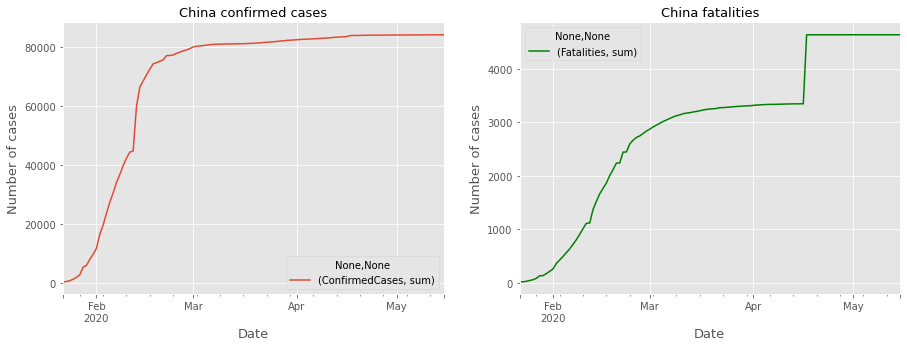

In [170]:
# Plot confirmed and fatalities together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
get_country_data(train_data,'China')[0].plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

# Plot fatalities only
get_country_data(train_data,'China')[1].plot(ax=ax2, color='green')
ax2.set_title("China fatalities", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)
#plt.savefig("trends-china.png")

We see confirmed cases and fatalities trend lines flattening out, indicating a plateau of infections and deaths. We also see some choppy data due to changes in reporting methodologies. But we see how the _curve flattens_, which is what every country is currently trying to do.

The global and China specific trends give us a sense of the current trends, and a glimpse into what we want to get our national trendline of confirmed cases and deaths to look like - i.e. _"flattening the curve"_.

## Other Interesting countries to look at: Canada, USA, Italy, Spain, South Korea, Germany, Tunisia <a class="anchor" id="EDA3"></a>

* __Italy__ & __Spain__ - rapid rise in cases and deaths. At one point, Italy was the global epicenter of the pandemic
* __US__ - currently the global epicenter of the pandemic and significantly higher cases and even deaths than any other country
* __South Korea__ - deemed a model for other countries to follow
* __Germany__ - is the fifth country in terms of total number of confirmed cases however Germany has the lowest death rate of only __5%__
* __Tunisia__ - it's interesting to see how a third world country is handeling the pandemic

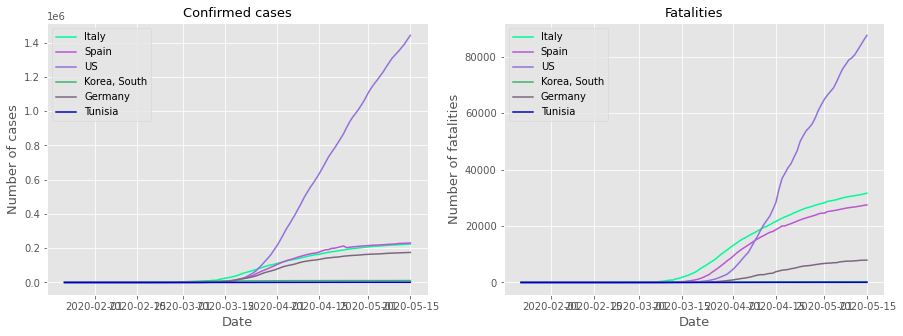

In [171]:
countries = ["Italy","Spain","US","Korea, South","Germany","Tunisia"]
colors = ['#00FA9A','#BA55D3','#9370DB','#3CB371','#7B687E','#0000CD']
# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

def plot_trend_by_country(df):
    
    for i in range(len(countries)):
        ax1.plot(get_country_data(df,countries[i])[0], label=countries[i],color=colors[i])
        ax2.plot(get_country_data(df,countries[i])[1], label=countries[i],color=colors[i])
    # Axes    
    ax1.set_title("Confirmed cases", size=13)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date", size=13)
    ax1.legend(loc="upper left")
    
    ax2.set_title("Fatalities", size=13)
    ax2.set_ylabel("Number of fatalities", size=13)
    ax2.set_xlabel("Date", size=13)
    ax2.legend(loc="upper left")
    
plot_trend_by_country(train_data)
#plt.savefig("other-trends.png")

# Machine Learning Models <a class="anchor" id="ML"></a>

In [172]:
## Splitting Data to train and validation data
train_ml=covid_by_date.iloc[:int(covid_by_date.shape[0]*0.90)] # Train data 90%
valid_ml=covid_by_date.iloc[int(covid_by_date.shape[0]*0.90):] # Validation data 10%

In [173]:
# Lists that contain the root mean square error for cases and fatalities predictions
model_scorescc=[]
model_scoresd =[]

## Linear regression <a class="anchor" id="LR"></a>

##### Predicting  Confirmed Cases

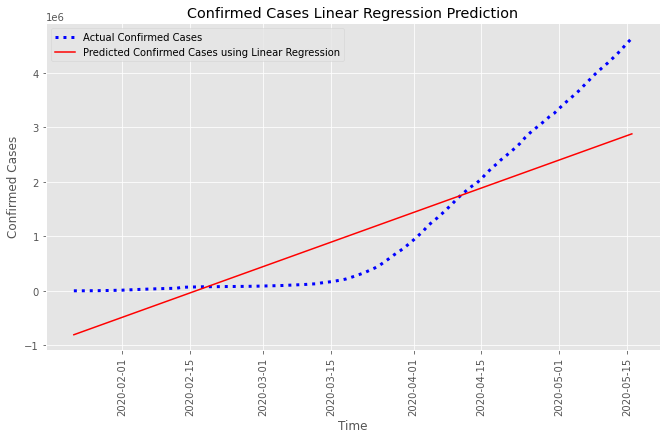

In [174]:
## Define the Linear Regression Model
LinRegcc=LinearRegression(normalize=True) 

## Predicting The Confirmed Cases
LinRegcc.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1)) # Fitting the linear regression Model to the data
prediction_cases_linreg=LinRegcc.predict(np.array(valid_ml["Days Since"]).reshape(-1,1)) # Predicting the values of the test data
model_scorescc.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_cases_linreg))) # Calculating the mean square error

## Plotting the results
plt.figure(figsize=(11,6))
prediction_linreg_cc=LinRegcc.predict(np.array(covid_by_date["Days Since"]).reshape(-1,1))
plt.plot(covid_by_date["Confirmed"],label="Actual Confirmed Cases",linewidth=3,linestyle='dotted',color="blue")
plt.plot(covid_by_date.index,prediction_linreg_cc,label="Predicted Confirmed Cases using Linear Regression",color='red')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Linear Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

##### Predicting  Fatalities

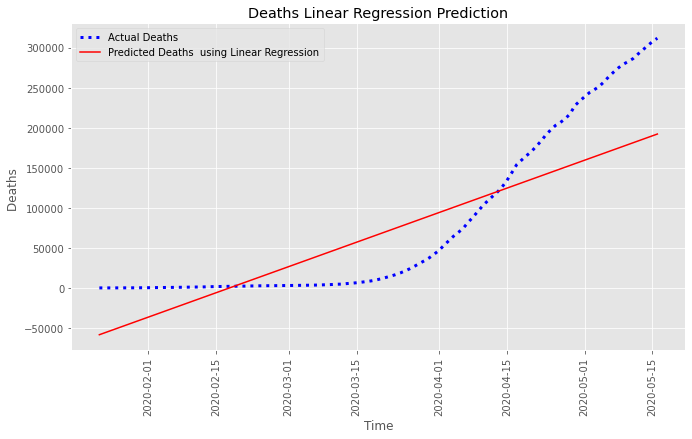

In [175]:
## Define the Linear Regression Model
LinRegd=LinearRegression(normalize=True)

## Predicting The Fatalities
LinRegd.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Deaths"]).reshape(-1,1)) # Fitting the linear regression Model to the data
prediction_deaths_linreg=LinRegd.predict(np.array(valid_ml["Days Since"]).reshape(-1,1)) # Predicting the values of the test data
model_scoresd.append(np.sqrt(mean_squared_error(valid_ml["Deaths"],prediction_deaths_linreg))) # Calculating the mean square error

## Plotting the results
plt.figure(figsize=(11,6))
prediction_linreg_d=LinRegd.predict(np.array(covid_by_date["Days Since"]).reshape(-1,1))
plt.plot(covid_by_date["Deaths"],label="Actual Deaths ",linewidth=3, linestyle='dotted',color="blue")
plt.plot(covid_by_date.index,prediction_linreg_d,label="Predicted Deaths  using Linear Regression",color='red')
plt.xlabel('Time')
plt.ylabel('Deaths ')
plt.title("Deaths Linear Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

__Observations__:

The Linear Regression Model is absolutely falling aprat. As it is clearly visible that the trend of Confirmed Cases in absolutely not Linear.

## Polynomial Regression <a class="anchor" id="PR"></a>

In [176]:
## Justifier le choix du degrés ?????

#### Plots of target features vs No. of days for random _Country_State_

In [177]:
# random_picks = random.choices(polyReg_train["Country_State"].unique(), k = 10)
# for value in random_picks:
#     train_temp = polyReg_train.loc[polyReg_train["Country_State"] == value]
#     test_temp = polyReg_test.loc[polyReg_test["Country_State"] == value]
#     train_temp_cc = train_temp["ConfirmedCases"].loc[polyReg_train["Country_State"] == value]
#     train_temp_ft = train_temp["Fatalities"].loc[polyReg_train["Country_State"] == value]
    
#     train_temp_X = train_temp.iloc[:, 4]
#     test_temp_X = test_temp.iloc[:, 2]
    
#     x = train_temp_X.to_numpy(dtype = float)
#     y_1 = train_temp_cc.to_numpy(dtype = float)
#     y_2= train_temp_ft.to_numpy(dtype = float)
#     x = x.reshape(-1,)
    
#     fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
#     ax1.plot(x, y_1, color ='green', label = value)
#     ax1.set_xlabel("No. of days")
#     ax1.set_ylabel('Confirmed cases')
#     ax1.set_title("Place: " + value)

    
    
#     ax2.plot(x, y_2, color ='red', label = value)
#     ax2.set_xlabel("No. of days")
#     ax2.set_ylabel('Fatalities')
#     ax2.set_title("Place: " + value)


Most of the plots for ConfirmedCases and Fatalities look like a degree 2 or sometimes a degree 4 polynomial.

As a starting model we're going to fit a degree 4 polynomial for them.

##### Predicting Confirmed Cases

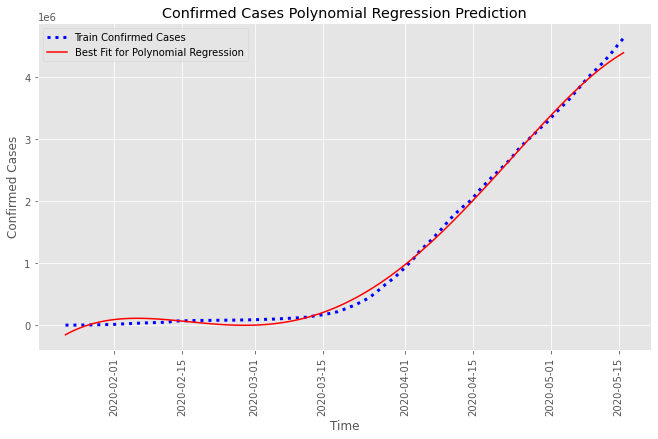

In [178]:
## Define the Polynomial Regression Model
poly = PolynomialFeatures(degree = 4)

## Predicting Confirmed Cases
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scorescc.append(rmse_poly)

## Plotting the results
comp_data=poly.fit_transform(np.array(covid_by_date["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)
plt.plot(covid_by_date["Confirmed"],label="Train Confirmed Cases",linewidth=3,linestyle='dotted', color="blue")
plt.plot(covid_by_date.index,predictions_poly, label="Best Fit for Polynomial Regression",color='red')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Polynomial Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

##### Predicting Fatalities

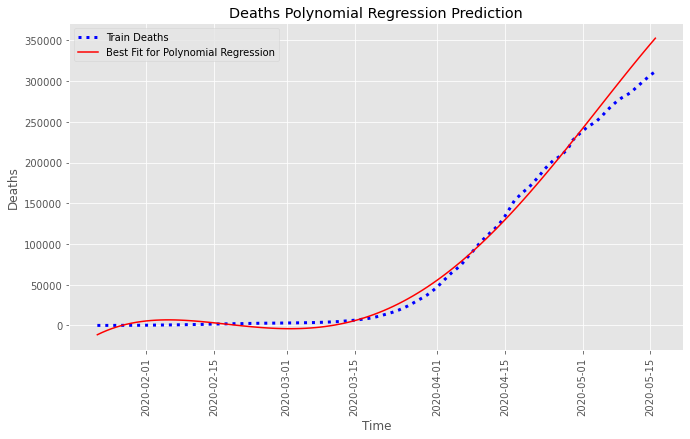

In [179]:
## Define the Polynomial Regression Model
polyd = PolynomialFeatures(degree = 4)

## Predicting Confirmed Cases
train_polyd=polyd.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_polyd=polyd.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
yd=train_ml["Deaths"]
linregd=LinearRegression(normalize=True)
linregd.fit(train_polyd,yd)
prediction_polyd=linregd.predict(valid_polyd)
rmse_polyd=np.sqrt(mean_squared_error(valid_ml["Deaths"],prediction_polyd))
model_scoresd.append(rmse_polyd)

## Plotting the results
comp_datad=polyd.fit_transform(np.array(covid_by_date["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_polyd=linregd.predict(comp_datad)
plt.plot(covid_by_date["Deaths"],label="Train Deaths",linewidth=3,linestyle='dotted', color="blue")
plt.plot(covid_by_date.index,predictions_polyd, label="Best Fit for Polynomial Regression",color='red')
plt.xlabel('Time')
plt.ylabel('Deaths')
plt.title("Deaths Polynomial Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

## Support Vector Machine Regressor <a class="anchor" id="svm"></a>

##### Predicting Confirmed Cases

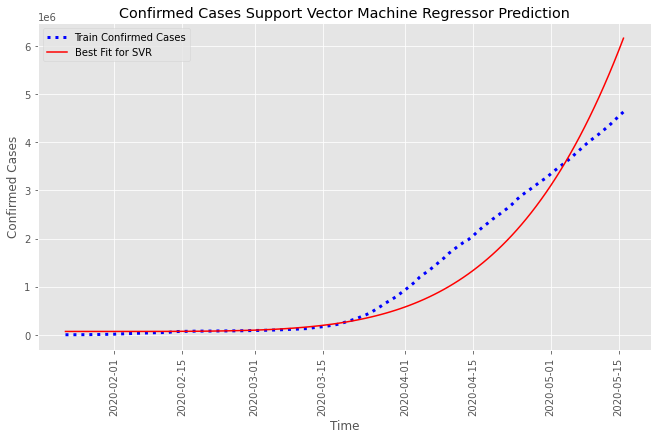

In [180]:
## Intializing SVR Model
svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)

## Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
model_scorescc.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

## Plotting the results
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(covid_by_date["Days Since"]).reshape(-1,1))
plt.plot(covid_by_date["Confirmed"],label="Train Confirmed Cases",linewidth=3,linestyle='dotted', color="blue")
plt.plot(covid_by_date.index,prediction_svm,label="Best Fit for SVR",color='red')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Support Vector Machine Regressor Prediction")
plt.xticks(rotation=90)
plt.legend()

#### Predicting Fatalities

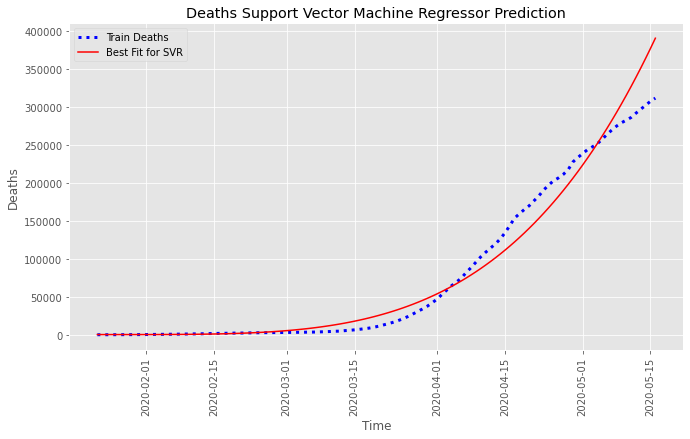

In [181]:
## Intializing SVR Model
svmd=SVR(C=1,degree=4,kernel='poly',epsilon=0.01)

## Fitting model on the training data
svmd.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Deaths"]).reshape(-1,1))
prediction_valid_svmd=svmd.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
model_scoresd.append(np.sqrt(mean_squared_error(valid_ml["Deaths"],prediction_valid_svmd)))

## Plotting the results
plt.figure(figsize=(11,6))
prediction_svmd=svmd.predict(np.array(covid_by_date["Days Since"]).reshape(-1,1))
plt.plot(covid_by_date["Deaths"],label="Train Deaths",linewidth=3,linestyle='dotted', color="blue")
plt.plot(covid_by_date.index,prediction_svmd,label="Best Fit for SVR",color='red')
plt.xlabel('Time')
plt.ylabel('Deaths')
plt.title("Deaths Support Vector Machine Regressor Prediction")
plt.xticks(rotation=90)
plt.legend()

## Predictions <a class="anchor" id="Predictions1"></a>

##### Cases Predictions from 17/05/2020 to 31/05/2020

In [182]:
new_date=[]
new_prediction_poly=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,16):
    new_date_poly=poly.fit_transform(np.array(covid_by_date["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])
    new_date.append(covid_by_date.index[-1]+timedelta(days=i))
    new_prediction_lr.append(LinRegcc.predict(np.array(covid_by_date["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(covid_by_date["Days Since"].max()+i).reshape(-1,1))[0])

In [225]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
#render_mpl_table(model_predictions, header_columns=0, col_width=3.5) 
model_predictions

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-05-17,2911655,4442890,6435822
1,2020-05-18,2943698,4482504,6715035
2,2020-05-19,2975740,4517758,7003958
3,2020-05-20,3007783,4548428,7302843
4,2020-05-21,3039826,4574287,7611946
5,2020-05-22,3071869,4595103,7931525
6,2020-05-23,3103912,4610639,8261846
7,2020-05-24,3135955,4620658,8603175
8,2020-05-25,3167998,4624915,8955788
9,2020-05-26,3200040,4623164,9319960


Text(0.5, 1.0, 'Cases prediction between 17-05-2020 and 31-05-2020 with Polynomial Regression Model')

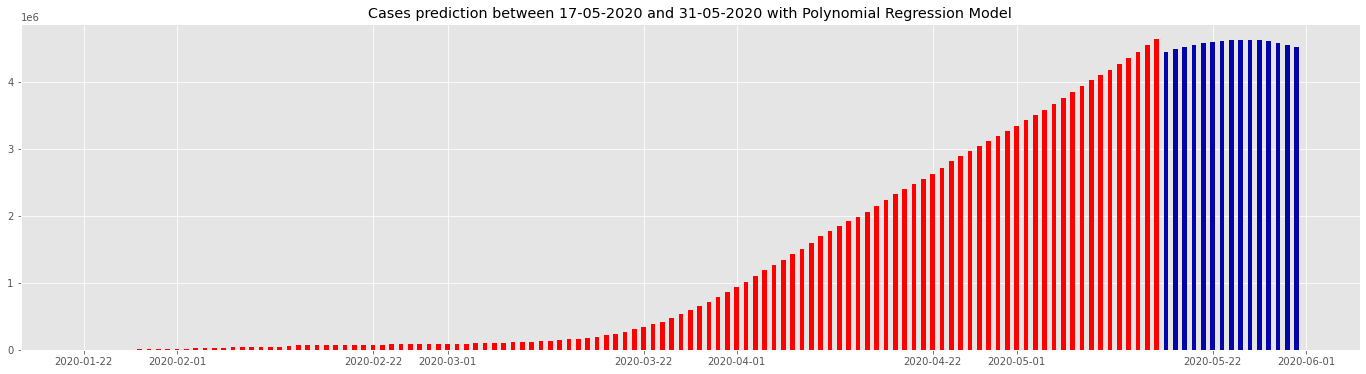

In [184]:
plt.figure(figsize=(24,6))
plt.bar(covid_by_date.index,covid_by_date["Confirmed"],width = 0.5, color='red')
plt.bar(model_predictions["Dates"],model_predictions["Polynonmial Regression Prediction"],width = 0.5, color='#0504aa')
plt.title("Cases prediction between 17-05-2020 and 31-05-2020 with Polynomial Regression Model")

##### Deaths Predictions from 17/05/2020 to 31/05/2020

In [185]:
new_dated=[]
new_prediction_polyd=[]
new_prediction_lrd=[]
new_prediction_svmd=[]
for i in range(1,16):
    new_date_polyd=polyd.fit_transform(np.array(covid_by_date["Days Since"].max()+i).reshape(-1,1))
    new_prediction_polyd.append(linregd.predict(new_date_polyd)[0])
    new_dated.append(covid_by_date.index[-1]+timedelta(days=i))
    new_prediction_lrd.append(LinRegd.predict(np.array(covid_by_date["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svmd.append(svmd.predict(np.array(covid_by_date["Days Since"].max()+i).reshape(-1,1))[0])

In [224]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
model_predictionsd=pd.DataFrame(zip(new_dated,new_prediction_lrd,new_prediction_polyd,new_prediction_svmd),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
#render_mpl_table(model_predictionsd, header_columns=0, col_width=3.5)
model_predictionsd

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-05-17,194317,359660,404511
1,2020-05-18,196497,366411,418633
2,2020-05-19,198676,373029,433121
3,2020-05-20,200855,379501,447983
4,2020-05-21,203034,385816,463224
5,2020-05-22,205213,391962,478851
6,2020-05-23,207392,397927,494870
7,2020-05-24,209571,403698,511288
8,2020-05-25,211750,409264,528111
9,2020-05-26,213929,414611,545347


Text(0.5, 1.0, 'Deaths prediction between 17-05-2020 and 31-05-2020 with Polynomial Regression Model')

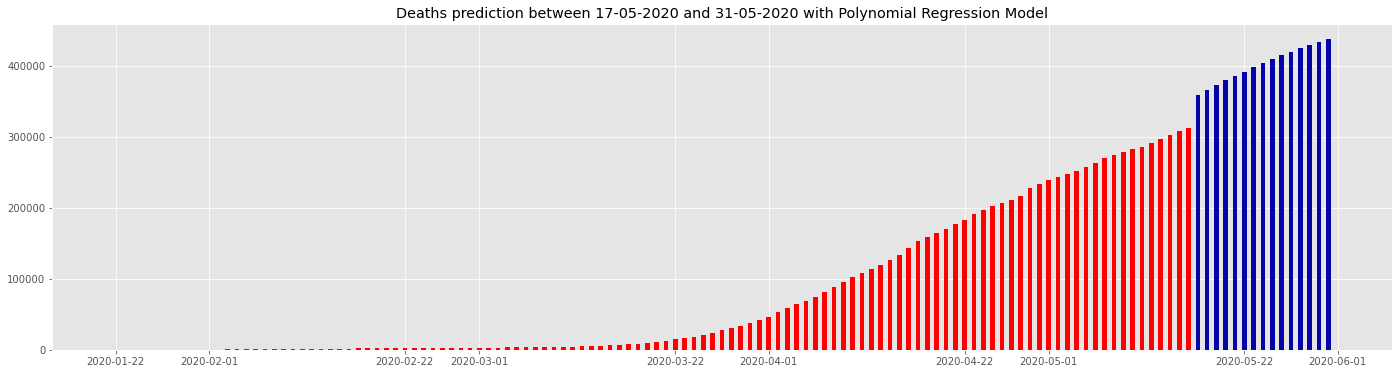

In [187]:
plt.figure(figsize=(24,6))
plt.bar(covid_by_date.index,covid_by_date["Deaths"],width = 0.5, color='red')
plt.bar(model_predictionsd["Dates"],model_predictionsd["Polynonmial Regression Prediction"],width = 0.5, color='#0504aa')
plt.title("Deaths prediction between 17-05-2020 and 31-05-2020 with Polynomial Regression Model")

# Time Series Models <a class="anchor" id="TS"></a>

## ARIMA <a class="anchor" id="arima"></a>

Autoregressive integrated moving average (ARIMA) models are mainly used for time-series analysis, since they are capable to predict the future values of a variable based only on its historical evolution. ARIMA models can be understood by dividing them in three main concepts, each of them with a related parameter:

* __AR__: the regression of the predicted variable is based on its previous values (lags). The  p  parameter defines the number of these terms.
\begin{equation}
 \sum_{i=1}^{p} \Phi_i y_{t-i}
 \end{equation}
* __I__: data values used for the regression are differenciated until they are stationary. Instead of working with  yt , it uses terms of . Parameter  d  is related to the number of differences need for stationarity.

 \begin{equation}
 y'_t \sim y_t - y_{t-1}
 \end{equation}
* __MA__: the error of the regression is based on a linear combination of error terms from the past (lags of errors). Parameter  q  is the number of lagged forecast errors in the prediction equation.
\begin{equation}
 \sum_{i=1}^{q} \theta_i \epsilon_{t-i}
 \end{equation}
 
In general, the model can be written as:
 \begin{equation}
 y'_t =  c +  \Phi_1 y'_{t-1} + .... + \Phi_p y'_{t-p} + \theta_1 \epsilon_{t-1} + .... + \theta_q \epsilon_{t-q} - \epsilon_t
 \end{equation}

In [188]:
model_train=covid_by_date.iloc[:int(covid_by_date.shape[0]*0.90)]
valid=covid_by_date.iloc[int(covid_by_date.shape[0]*0.90):]
y_pred=valid.copy()
y_predd = valid.copy()

##### Predicting Confirmed Cases

In [189]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=4,max_q=4,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=2115.439, BIC=2120.689, Time=0.007 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=2111.120, BIC=2118.995, Time=0.016 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=2109.468, BIC=2119.968, Time=0.080 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=2114.870, BIC=2127.995, Time=0.031 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=2112.770, BIC=2128.520, Time=0.069 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=2113.268, BIC=2121.143, Time=0.017 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=2113.278, BIC=2123.778, Time=0.029 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=2112.748, BIC=2125.873, Time=0.055 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=2113.839, BIC=2129.589, Time=0.091 seconds
Fit ARIMA(1,2,4)x(0,0,0,0) [intercept=True]; AIC=2108.128, BIC=2126.503, Time=0.105 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=2111.472, BIC=2121.972, Time=0.

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 4), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [190]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [191]:
model_scorescc.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

In [192]:
ARIMA_model_new_prediction=[]
for i in range(1,16):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction

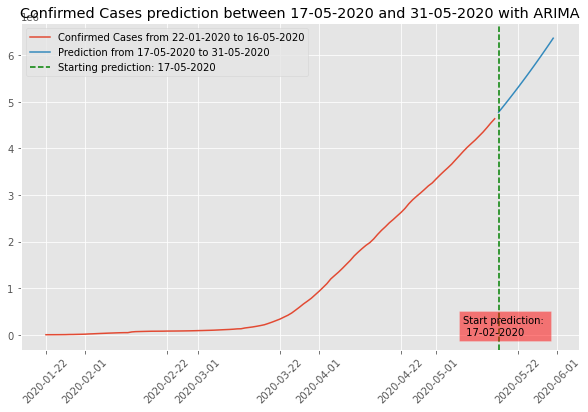

In [193]:
plt.figure(figsize=(10,6))
plt.plot(covid_by_date.index,covid_by_date["Confirmed"])
plt.plot(model_predictions["Dates"],model_predictions["ARIMA Model Prediction"])
plt.axvline(model_predictions["Dates"][0], color="green", linestyle="--")
plt.text(covid_by_date.index[107], 2, "Start prediction: \n 17-02-2020", bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(rotation=45)
plt.title("Confirmed Cases prediction between 17-05-2020 and 31-05-2020 with ARIMA")
plt.legend(['Confirmed Cases from 22-01-2020 to 16-05-2020', 'Prediction from 17-05-2020 to 31-05-2020',"Starting prediction: 17-05-2020"])

##### Predicting Fatalities

In [194]:
model_arimad= auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=4,max_q=4,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arimad.fit(model_train["Deaths"])

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1698.024, BIC=1703.274, Time=0.008 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1697.898, BIC=1705.773, Time=0.021 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1693.139, BIC=1703.639, Time=0.070 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1688.134, BIC=1701.259, Time=0.146 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=1690.059, BIC=1705.809, Time=0.235 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1698.309, BIC=1706.184, Time=0.014 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1691.358, BIC=1701.858, Time=0.130 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1692.437, BIC=1705.562, Time=0.194 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=1688.586, BIC=1704.336, Time=0.251 seconds
Fit ARIMA(1,2,4)x(0,0,0,0) [intercept=True]; AIC=1677.134, BIC=1695.509, Time=0.279 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1699.991, BIC=1710.491, Time=0.

ARIMA(maxiter=50, method='lbfgs', order=(3, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [195]:
prediction_arimad=model_arimad.predict(len(valid))
y_predd["ARIMA Model Prediction"]=prediction_arimad
model_scoresd.append(np.sqrt(mean_squared_error(valid["Deaths"],prediction_arimad)))

In [196]:
ARIMA_model_new_predictiond=[]
for i in range(1,16):
    ARIMA_model_new_predictiond.append(model_arimad.predict(len(valid)+i)[-1])
model_predictionsd["ARIMA Model Prediction"]=ARIMA_model_new_predictiond

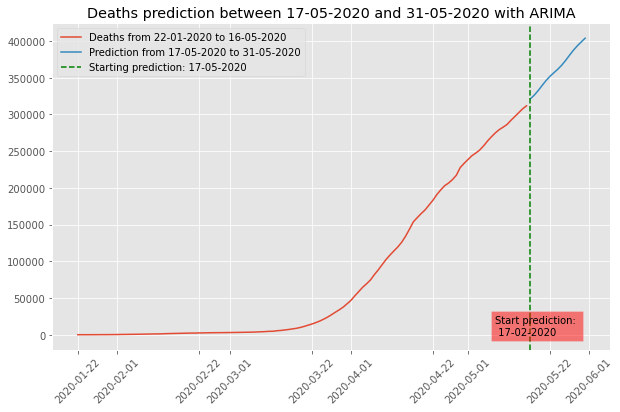

In [197]:
plt.figure(figsize=(10,6))
plt.plot(covid_by_date.index,covid_by_date["Deaths"])
plt.plot(model_predictionsd["Dates"],model_predictionsd["ARIMA Model Prediction"])
plt.axvline(model_predictionsd["Dates"][0], color="green", linestyle="--")
plt.text(covid_by_date.index[107], 2, "Start prediction: \n 17-02-2020", bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(rotation=45)
plt.title("Deaths prediction between 17-05-2020 and 31-05-2020 with ARIMA")
plt.legend(['Deaths from 22-01-2020 to 16-05-2020', 'Prediction from 17-05-2020 to 31-05-2020',"Starting prediction: 17-05-2020"])

## SARIMA <a class="anchor" id="sarima"></a>

In [198]:
y_preds = valid.copy()
y_predsd = valid.copy()

##### Predicting Cases

In [199]:
model_sarima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=3,max_q=3,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(1,0,1,7) [intercept=True]; AIC=2115.997, BIC=2126.496, Time=0.056 seconds
Fit ARIMA(0,2,0)x(0,0,0,7) [intercept=True]; AIC=2115.439, BIC=2120.689, Time=0.007 seconds
Fit ARIMA(1,2,0)x(1,0,0,7) [intercept=True]; AIC=2108.382, BIC=2118.882, Time=0.031 seconds
Fit ARIMA(0,2,1)x(0,0,1,7) [intercept=True]; AIC=2099.891, BIC=2110.391, Time=0.111 seconds
Fit ARIMA(0,2,0)x(0,0,0,7) [intercept=False]; AIC=2114.449, BIC=2117.074, Time=0.006 seconds
Fit ARIMA(0,2,1)x(0,0,0,7) [intercept=True]; AIC=2111.120, BIC=2118.995, Time=0.016 seconds
Fit ARIMA(0,2,1)x(1,0,1,7) [intercept=True]; AIC=2103.707, BIC=2116.832, Time=0.058 seconds
Fit ARIMA(0,2,1)x(0,0,2,7) [intercept=True]; AIC=2103.437, BIC=2116.562, Time=0.053 seconds
Fit ARIMA(0,2,1)x(1,0,0,7) [intercept=True]; AIC=2103.431, BIC=2113.931, Time=0.044 seconds
Fit ARIMA(0,2,1)x(1,0,2,7) [intercept=True]; AIC=2103.544, BIC=2119.294, Time=0.548 seconds
Fit ARIMA(0,2,0)x(0,0,1,7) [intercep

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 1, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [200]:
prediction_sarima=model_sarima.predict(len(valid))
y_preds["SARIMA Model Prediction"]=prediction_sarima

In [201]:
model_scorescc.append(np.sqrt(mean_squared_error(y_preds["Confirmed"],y_preds["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_preds["Confirmed"],y_preds["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  34733.72633024966


In [202]:
SARIMA_model_new_prediction=[]
for i in range(1,16):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction

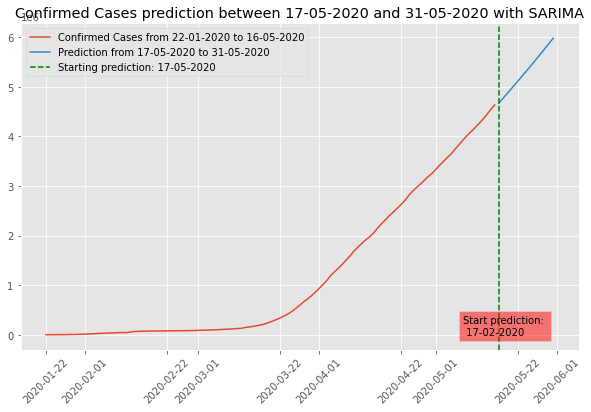

In [203]:
plt.figure(figsize=(10,6))
plt.plot(covid_by_date.index,covid_by_date["Confirmed"])
plt.plot(model_predictions["Dates"],model_predictions["SARIMA Model Prediction"])
plt.axvline(model_predictions["Dates"][0], color="green", linestyle="--")
plt.text(covid_by_date.index[107], 2, "Start prediction: \n 17-02-2020", bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(rotation=45)
plt.title("Confirmed Cases prediction between 17-05-2020 and 31-05-2020 with SARIMA")
plt.legend(['Confirmed Cases from 22-01-2020 to 16-05-2020', 'Prediction from 17-05-2020 to 31-05-2020',"Starting prediction: 17-05-2020"])

##### Predicting Fatalities

In [204]:
model_sarimad= auto_arima(model_train["Deaths"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=3,max_q=3,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarimad.fit(model_train["Deaths"])

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(1,0,1,7) [intercept=True]; AIC=1696.520, BIC=1707.020, Time=0.117 seconds
Fit ARIMA(0,2,0)x(0,0,0,7) [intercept=True]; AIC=1698.024, BIC=1703.274, Time=0.006 seconds
Fit ARIMA(1,2,0)x(1,0,0,7) [intercept=True]; AIC=1684.335, BIC=1694.835, Time=0.100 seconds
Fit ARIMA(0,2,1)x(0,0,1,7) [intercept=True]; AIC=1687.609, BIC=1698.109, Time=0.091 seconds
Fit ARIMA(0,2,0)x(0,0,0,7) [intercept=False]; AIC=1696.193, BIC=1698.818, Time=0.006 seconds
Fit ARIMA(1,2,0)x(0,0,0,7) [intercept=True]; AIC=1698.309, BIC=1706.184, Time=0.014 seconds
Fit ARIMA(1,2,0)x(2,0,0,7) [intercept=True]; AIC=1685.395, BIC=1698.520, Time=0.192 seconds
Fit ARIMA(1,2,0)x(1,0,1,7) [intercept=True]; AIC=1685.562, BIC=1698.687, Time=0.145 seconds
Fit ARIMA(1,2,0)x(0,0,1,7) [intercept=True]; AIC=1690.831, BIC=1701.330, Time=0.101 seconds
Fit ARIMA(1,2,0)x(2,0,1,7) [intercept=True]; AIC=1687.376, BIC=1703.126, Time=0.289 seconds
Fit ARIMA(0,2,0)x(1,0,0,7) [intercep

ARIMA(maxiter=50, method='lbfgs', order=(3, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [205]:
prediction_sarimad=model_sarimad.predict(len(valid))
y_predsd["SARIMA Model Prediction"]=prediction_sarimad

In [206]:
model_scoresd.append(np.sqrt(mean_squared_error(y_predsd["Confirmed"],y_predsd["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_predsd["Confirmed"],y_predsd["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  3867251.915810777


In [207]:
SARIMA_model_new_predictiond=[]
for i in range(1,16):
    SARIMA_model_new_predictiond.append(model_sarimad.predict(len(valid)+i)[-1])
model_predictionsd["SARIMA Model Prediction"]=SARIMA_model_new_predictiond

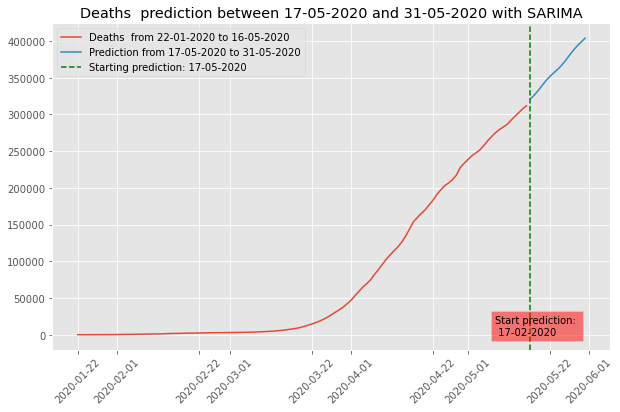

In [208]:
plt.figure(figsize=(10,6))
plt.plot(covid_by_date.index,covid_by_date["Deaths"])
plt.plot(model_predictionsd["Dates"],model_predictionsd["SARIMA Model Prediction"])
plt.axvline(model_predictionsd["Dates"][0], color="green", linestyle="--")
plt.text(covid_by_date.index[107], 2, "Start prediction: \n 17-02-2020", bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(rotation=45)
plt.title("Deaths  prediction between 17-05-2020 and 31-05-2020 with SARIMA")
plt.legend(['Deaths  from 22-01-2020 to 16-05-2020', 'Prediction from 17-05-2020 to 31-05-2020',"Starting prediction: 17-05-2020"])

## Predictions <a class="anchor" id="predictions2"></a>

##### Cases

In [223]:
#render_mpl_table(model_predictions[["Dates","ARIMA Model Prediction","SARIMA Model Prediction"]], header_columns=0, col_width=3.5)
model_predictions[["Dates","ARIMA Model Prediction","SARIMA Model Prediction"]]

,Dates,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-05-17,4774429,4668504
1,2020-05-18,4877920,4757503
2,2020-05-19,4982942,4847232
3,2020-05-20,5089494,4937693
4,2020-05-21,5197577,5028884
5,2020-05-22,5307190,5120806
6,2020-05-23,5418334,5213459
7,2020-05-24,5531009,5306843
8,2020-05-25,5645213,5400957
9,2020-05-26,5760949,5495802


##### Fatalities

In [222]:
#render_mpl_table(model_predictionsd[["Dates","ARIMA Model Prediction","SARIMA Model Prediction"]], header_columns=0, col_width=3.5)
model_predictionsd[["Dates","ARIMA Model Prediction","SARIMA Model Prediction"]]

,Dates,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-05-17,321357,321357
1,2020-05-18,326408,326408
2,2020-05-19,332602,332602
3,2020-05-20,339495,339495
4,2020-05-21,346160,346160
5,2020-05-22,351903,351903
6,2020-05-23,356778,356778
7,2020-05-24,361522,361522
8,2020-05-25,366981,366981
9,2020-05-26,373471,373471


# Models' Summary <a class="anchor" id="summary"></a>

##### Cases' Predictions

In [221]:
# render_mpl_table(model_predictions, header_columns=0, col_width=3.5)
model_predictions

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-05-17,2911655,4442890,6435822,4774429,4668504
1,2020-05-18,2943698,4482504,6715035,4877920,4757503
2,2020-05-19,2975740,4517758,7003958,4982942,4847232
3,2020-05-20,3007783,4548428,7302843,5089494,4937693
4,2020-05-21,3039826,4574287,7611946,5197577,5028884
5,2020-05-22,3071869,4595103,7931525,5307190,5120806
6,2020-05-23,3103912,4610639,8261846,5418334,5213459
7,2020-05-24,3135955,4620658,8603175,5531009,5306843
8,2020-05-25,3167998,4624915,8955788,5645213,5400957
9,2020-05-26,3200040,4623164,9319960,5760949,5495802


##### Cases' Root Mean Square Error

In [212]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","ARIMA Model","SARIMA Model"]
model_summary=pd.DataFrame(zip(model_names,model_scorescc),columns=["Model Name",
                                                                    "Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])

In [220]:
#render_mpl_table(model_summary, header_columns=0, col_width=3.5)
model_summary

,Model Name,Root Mean Squared Error
3,ARIMA Model,22972
4,SARIMA Model,34734
1,Polynomial Regression,106251
2,Support Vector Machine Regressor,873500
0,Linear Regression,1453304


##### Fatalities' Predictions

In [219]:
#render_mpl_table(model_predictionsd, header_columns=0, col_width=3.5)
model_predictionsd

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-05-17,194317,359660,404511,321357,321357
1,2020-05-18,196497,366411,418633,326408,326408
2,2020-05-19,198676,373029,433121,332602,332602
3,2020-05-20,200855,379501,447983,339495,339495
4,2020-05-21,203034,385816,463224,346160,346160
5,2020-05-22,205213,391962,478851,351903,351903
6,2020-05-23,207392,397927,494870,356778,356778
7,2020-05-24,209571,403698,511288,361522,361522
8,2020-05-25,211750,409264,528111,366981,366981
9,2020-05-26,213929,414611,545347,373471,373471


##### Fatalities' Root Mean Square Error

In [218]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","ARIMA Model","SARIMA Model"]
model_summaryd=pd.DataFrame(zip(model_names,model_scoresd),columns=["Model Name",
                                                                    "Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
#render_mpl_table(model_summaryd, header_columns=0, col_width=3.5)
model_summaryd

,Model Name,Root Mean Squared Error
3,ARIMA Model,2757
1,Polynomial Regression,28894
2,Support Vector Machine Regressor,44730
0,Linear Regression,105653
4,SARIMA Model,3867252


# Conclusions <a class="anchor" id="conclusions"></a>

In this notebook we tried to analyse existing covid-19 data for 2 different reasons :

* We looked for insights about the spread of the coronavirus, the trends and the similarities between some countries throught data visualisation with doing so we came to these conclusions:
    * The number of *Closed Cases* is incrsing with time which is a good sign
    * The number of *Active Cases* is also increasing with time which means that we're not close to beating the pandemic
    * The *Recovery Rates* have known a slow decrease in the last month, however it looks like they're starting to increase againg xhich is a good sign
    * The *Mortality Rates* have known an unfortunate increase but it looks like they will decrease a little by the end of the month of May.
    * The *Growth Factor* indicates an exponential growth for all types of cases however it's starting to mover towards 1 which could be a good sign.
    * Clustering the countries allowed us to figure out which countries are similar in terms of the number of confirmed cases, deaths and recovery, we also figured out that the case of USA is a unique case since it belongs to its own cluster.
    * The global curve numbers are strongly affected by the vector zero country, China. In fact if we exclude china from the data, the global curve seems to the curve of the __SIR model__ which is a classical epidemilogy model.
    * China seems to have already *flattened* its confirmed cases and fatalities curves which is what all the countries are aiming to do.
    
* We also tried to forecast covid-19 confirmed cases and fatalities using different types of models, we aimed for the end of the month of May and we came to thease conclusions:
    * When it comes to machine learning models; first,linear regression failed miserably which is logical since we can see that the curve is clearly not linear, second, polynomial regression which seems to have given us descent results for both confirmed cases and fatalities, and finaly support vector machine regressor which did not give us good results.
    * When it comes to time series models; first, Arima gave us somewhat great reults for both confirmed cases and fatalities and second, SARIMA which gave us descent results when it comes to confirmed cases prediction but the fatalities predictions where way off.
    * Overall, we can say that with evaluating these models by *Root Mean Square  Error*,  the time series models seem to perform better on this type of data.
    * On another note, since ARIMA seems to be the winning model, its predictions showed that the nomber of cases and fatalities will continue increasing at least until the end of th month of May.
    
Finally, like we said earlier, since the global curve (excluding China) seems to fit with th SIR model, it seems interesting to try and implemetn some epidemiology models and see if they will succeed in forecasting confirmed and death cases. it also seems interesting to try some deep learning models like LSTM for exemple.